In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# @title
from google.colab import userdata
from huggingface_hub import login

token = userdata.get("HUGGINGFACE_HUB_TOKEN")
login(token=token)

SecretNotFoundError: Secret HUGGINGFACE_HUB_TOKEN does not exist.

In [4]:
!pip install -q transformers datasets accelerate peft trl bitsandbytes

!pip install -q -U bitsandbytes
!pip install -q -U transformers
!pip install -q -U accelerate
!pip install -q -U peft
!pip install -q -U trl
!pip install -q -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 23.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


In [ ]:
# @title
# ============================================================
# ⚙️ Step 3: PPO (Reinforcement Learning) - 안전 버전
# ============================================================

import os
import json
import random
import torch
from datasets import Dataset
from trl import PPOTrainer, PPOConfig, create_reference_model
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    BitsAndBytesConfig
)
from peft import PeftModel, LoraConfig

# ============================================================
# 1. 데이터 샘플 비율 설정
# ============================================================
DATA_SAMPLE_RATIO = 0.1

def sample_data(data_list, ratio=0.05, seed=42):
    random.seed(seed)
    n_sample = max(1, int(len(data_list) * ratio))
    return random.sample(data_list, n_sample)

In [ ]:
# @title
# ============================================================
# 2. JSON 파일 로드 함수
# ============================================================
def load_custom_json(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
        return data.get("data_info", [])

# ============================================================
# 3. 데이터 로드 및 샘플링
# ============================================================
sft_data = sample_data(load_custom_json("/content/drive/MyDrive/project_2/data/train/RLHF_train/SFT.json"), DATA_SAMPLE_RATIO)
rm_data = sample_data(load_custom_json("/content/drive/MyDrive/project_2/data/train/RLHF_train/RM.json"), DATA_SAMPLE_RATIO)
ppo_data = sample_data(load_custom_json("/content/drive/MyDrive/project_2/data/train/RLHF_train/PPO.json"), DATA_SAMPLE_RATIO)

# ============================================================
# 0️⃣ 경로 설정
# ============================================================
output_dir = "/content/drive/MyDrive/llama3_ppo"
MODEL_NAME = "meta-llama/Llama-3.2-1B"
SFT_MODEL_PATH = "/content/drive/MyDrive/llama3_sft/llama3_1b_sft0.5/sft_lora"
RM_MODEL_PATH = "/content/drive/MyDrive/project_2/llama_3.2_1b_rm/rm_v6_1"
PPO_SAVE_PATH = f"{output_dir}/ppo_lora"

# ============================================================
# 1️⃣ Tokenizer 로드
# ============================================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

In [ ]:
# @title
# ============================================================
# 3️⃣ SFT 모델 로드 (Policy)
# ============================================================
print("📥 SFT LoRA 모델 로드 중...")
base_policy = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto"
)
policy_model = PeftModel.from_pretrained(base_policy, SFT_MODEL_PATH)
policy_model = policy_model.merge_and_unload()
policy_model.config.pad_token_id = tokenizer.pad_token_id
print("✅ Policy 모델 로드 완료")

# ============================================================
# 4️⃣ Reference 모델 생성
# ============================================================
ref_model = create_reference_model(policy_model)
print("✅ Reference 모델 생성 완료")

# ============================================================
# 5️⃣ RM 모델 로드 (Reward Model) 및 value 모델
# ============================================================
print("📥 RM LoRA 모델 로드 중...")
base_rm = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1,
    quantization_config=bnb_config,
    device_map="auto"
)
reward_model = PeftModel.from_pretrained(base_rm, RM_MODEL_PATH)
reward_model.config.pad_token_id = tokenizer.pad_token_id
print("✅ Reward 모델 로드 완료")

value_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=1,
    quantization_config=bnb_config,
    device_map="auto"
)
value_model.config.pad_token_id = tokenizer.pad_token_id

📥 SFT LoRA 모델 로드 중...


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


✅ Policy 모델 로드 완료
✅ Reference 모델 생성 완료
📥 RM LoRA 모델 로드 중...


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Reward 모델 로드 완료


Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# @title
# ============================================================
# 6️⃣ PPO 데이터셋 구성
# ============================================================
# query 컬럼만 남기고 Dataset 생성
texts = [
     d.get("question", "").strip()
     for d in ppo_data
     if "question" in d and d["question"].strip() != ""
]

# 3️⃣ Tokenize
tokenized = tokenizer(
    texts,
    truncation=True,
    padding="max_length",
    max_length=256,  # 필요에 따라 조정 (보통 128~512)
    return_tensors="pt",  # PyTorch 텐서로 반환
)

# 4️⃣ Dataset으로 변환
ppo_dataset = Dataset.from_dict({
    "input_ids": tokenized["input_ids"],
    "attention_mask": tokenized["attention_mask"],
})

# ============================================================
# collate_fn (방어적)
# ============================================================
def collate_fn(batch):
    if len(batch) == 0:
        raise ValueError("Empty batch passed to collate_fn")

    try:
        input_ids = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(b["input_ids"], dtype=torch.long) for b in batch],
            batch_first=True, padding_value=tokenizer.pad_token_id
        )
        attention_mask = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(b["attention_mask"], dtype=torch.long) for b in batch],
            batch_first=True, padding_value=0
        )
    except Exception as e:
        print("❌ Collate failed on batch:")
        print(batch)
        raise e

    return {"input_ids": input_ids, "attention_mask": attention_mask}

In [ ]:
# @title
# ============================================================
# 7️⃣ PPO 설정
# ============================================================
ppo_config = PPOConfig(
    batch_size=2,
    mini_batch_size=1,
    learning_rate=1.4e-5,
    report_to="none",
    num_sample_generations=0
)

# ============================================================
# 8️⃣ PPO Trainer 정의
# ============================================================
ppo_trainer = PPOTrainer(
    model=policy_model,
    ref_model=ref_model,
    value_model=value_model,
    reward_model=reward_model,
    processing_class=tokenizer,
    train_dataset=ppo_dataset,
    data_collator=collate_fn,
    args=ppo_config,
)

/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:164: UserWarning: This trainer will soon be moved to trl.experimental and is a candidate for removal. If you rely on it and want it to remain, please share your comments here: https://github.com/huggingface/trl/issues/4223. Silence this warning by setting environment variable TRL_EXPERIMENTAL_SILENCE=1.
  warnings.warn(


In [ ]:
# @title
# ============================================================
# 9️⃣ PPO 학습 루프
# ============================================================
import time
print("🚀 PPO 학습 시작...")
start_time = time.time()

ppo_trainer.train()

end_time = time.time()
print(f"✅ PPO 학습 완료 - Total Time: {end_time - start_time:.2f}s")

# ============================================================
# 🔟 모델 저장
# ============================================================
ppo_trainer.save_model(PPO_SAVE_PATH)
tokenizer.save_pretrained(PPO_SAVE_PATH)
print(f"✅ PPO 모델 저장 완료: {PPO_SAVE_PATH}")

🚀 PPO 학습 시작...
===training policy===


/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:566: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  rewards[[actual_start, actual_end]] += scores


Step,Training Loss


/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:566: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  rewards[[actual_start, actual_end]] += scores


✅ PPO 학습 완료 - Total Time: 7762.33s
✅ PPO 모델 저장 완료: /content/drive/MyDrive/llama3_ppo/ppo_lora


In [ ]:
# @title
# ============================================================
# ⚙️ Step 3: PPO (Reinforcement Learning) - 안전 버전
# ============================================================

import os
import json
import random
import torch
from datasets import Dataset
from trl import PPOTrainer, PPOConfig, create_reference_model
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    BitsAndBytesConfig
)
from peft import PeftModel, LoraConfig

# ============================================================
# 1. 데이터 샘플 비율 설정
# ============================================================
DATA_SAMPLE_RATIO = 0.5

def sample_data(data_list, ratio=0.05, seed=42):
    random.seed(seed)
    n_sample = max(1, int(len(data_list) * ratio))
    return random.sample(data_list, n_sample)

# ============================================================
# 2. JSON 파일 로드 함수
# ============================================================
def load_custom_json(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
        return data.get("data_info", [])

# ============================================================
# 3. 데이터 로드 및 샘플링
# ============================================================
sft_data = sample_data(load_custom_json("/content/drive/MyDrive/project_2/data/train/RLHF_train/SFT.json"), DATA_SAMPLE_RATIO)
rm_data = sample_data(load_custom_json("/content/drive/MyDrive/project_2/data/train/RLHF_train/RM.json"), DATA_SAMPLE_RATIO)
ppo_data = sample_data(load_custom_json("/content/drive/MyDrive/project_2/data/train/RLHF_train/PPO.json"), DATA_SAMPLE_RATIO)

# ============================================================
# 0️⃣ 경로 설정
# ============================================================
output_dir = "/content/drive/MyDrive/llama3_ppo/ver2"
MODEL_NAME = "meta-llama/Llama-3.2-1B"
SFT_MODEL_PATH = "/content/drive/MyDrive/llama3_sft/llama3_1b_sft0.5/sft_lora"
RM_MODEL_PATH = "/content/drive/MyDrive/project_2/llama_3.2_1b_rm/rm_v6_1"
PPO_SAVE_PATH = f"{output_dir}/ppo_lora"

# ============================================================
# 1️⃣ Tokenizer 로드
# ============================================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# ============================================================
# 6️⃣ PPO 데이터셋 구성
# ============================================================
# query 컬럼만 남기고 Dataset 생성
texts = [
     d.get("question", "").strip()
     for d in ppo_data
     if "question" in d and d["question"].strip() != ""
]

# 3️⃣ Tokenize
tokenized = tokenizer(
    texts,
    truncation=True,
    padding="max_length",
    max_length=256,  # 필요에 따라 조정 (보통 128~512)
    return_tensors="pt",  # PyTorch 텐서로 반환
)

# 4️⃣ Dataset으로 변환
ppo_dataset = Dataset.from_dict({
    "input_ids": tokenized["input_ids"],
    "attention_mask": tokenized["attention_mask"],
})

# ============================================================
# collate_fn (방어적)
# ============================================================
def collate_fn(batch):
    if len(batch) == 0:
        raise ValueError("Empty batch passed to collate_fn")

    try:
        input_ids = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(b["input_ids"], dtype=torch.long) for b in batch],
            batch_first=True, padding_value=tokenizer.pad_token_id
        )
        attention_mask = torch.nn.utils.rnn.pad_sequence(
            [torch.tensor(b["attention_mask"], dtype=torch.long) for b in batch],
            batch_first=True, padding_value=0
        )
    except Exception as e:
        print("❌ Collate failed on batch:")
        print(batch)
        raise e

    return {"input_ids": input_ids, "attention_mask": attention_mask}

# ============================================================
# 7️⃣ PPO 설정
# ============================================================
ppo_config = PPOConfig(
    batch_size=2,
    mini_batch_size=1,
    learning_rate=1.4e-5,
    report_to="none",
    num_sample_generations=0
)

# ============================================================
# 8️⃣ PPO Trainer 정의
# ============================================================
ppo_trainer = PPOTrainer(
    model=policy_model,
    ref_model=ref_model,
    value_model=value_model,
    reward_model=reward_model,
    processing_class=tokenizer,
    train_dataset=ppo_dataset,
    data_collator=collate_fn,
    args=ppo_config,
)


# ============================================================
# 9️⃣ PPO 학습 루프
# ============================================================
import time
print("🚀 PPO 학습 시작...")
start_time = time.time()

ppo_trainer.train()

end_time = time.time()
print(f"✅ PPO 학습 완료 - Total Time: {end_time - start_time:.2f}s")

# ============================================================
# 🔟 모델 저장
# ============================================================
ppo_trainer.save_model(PPO_SAVE_PATH)
tokenizer.save_pretrained(PPO_SAVE_PATH)
print(f"✅ PPO 모델 저장 완료: {PPO_SAVE_PATH}")

/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:164: UserWarning: This trainer will soon be moved to trl.experimental and is a candidate for removal. If you rely on it and want it to remain, please share your comments here: https://github.com/huggingface/trl/issues/4223. Silence this warning by setting environment variable TRL_EXPERIMENTAL_SILENCE=1.
  warnings.warn(


🚀 PPO 학습 시작...
===training policy===


/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:566: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  rewards[[actual_start, actual_end]] += scores


Step,Training Loss


/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:566: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  rewards[[actual_start, actual_end]] += scores
/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:566: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  rewards[[actual_start, actual_end]] +=

Step,Training Loss


/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:566: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  rewards[[actual_start, actual_end]] += scores
/usr/local/lib/python3.12/dist-packages/trl/trainer/ppo_trainer.py:566: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  rewards[[actual_start, actual_end]] +=

✅ PPO 학습 완료 - Total Time: 39168.21s
✅ PPO 모델 저장 완료: /content/drive/MyDrive/llama3_ppo/ver2/ppo_lora


In [ ]:
# @title
# ============================================================
# 🔟 PPO 결과 저장 (policy model 저장)
# ============================================================

PPO_SAVE_PATH = "/content/drive/MyDrive/llama3_ppo/final"

# PPO policy (즉, 강화학습 후 언어모델 부분만) 저장
ppo_trainer.model.policy.save_pretrained(PPO_SAVE_PATH)
tokenizer.save_pretrained(PPO_SAVE_PATH)

print(f"✅ PPO 모델(policy) 저장 완료: {PPO_SAVE_PATH}")

✅ PPO 모델(policy) 저장 완료: /content/drive/MyDrive/llama3_ppo/final


In [ ]:
!pip install -q transformers accelerate bitsandbytes pandas tqdm peft

In [5]:
# @title
# =========================================================
# 1. 환경 설정
# =========================================================
import os
import torch
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from IPython.display import display

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Device: {device}")

# =========================================================
# 2. PPO 모델 로드 (양자화 + 안정 버전)
# =========================================================
BASE_MODEL = "meta-llama/Llama-3.2-1B"
PPO_MODEL_PATH = os.path.abspath("/content/drive/MyDrive/project2/1031/final_model")

# 4bit 양자화 설정 (VRAM 절약)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

# tokenizer는 반드시 학습 당시 Base 모델에서 불러와야 함
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token = tokenizer.eos_token

# 모델 로드
print("📥 PPO 모델 로드 중...")
model = AutoModelForCausalLM.from_pretrained(
    PPO_MODEL_PATH,
    quantization_config=bnb_config,
    device_map="auto",
    low_cpu_mem_usage=True
)
model.eval()
print("✅ PPO 모델 로드 완료!")

# =========================================================
# 3. 평가용 데이터 로드
# =========================================================
csv_path = "/content/drive/MyDrive/project2/project_2/sample_question.csv"
df = pd.read_csv(csv_path)
print(f"📄 데이터 크기: {df.shape}")
print("열 이름:", df.columns.tolist())

df = df.rename(columns={
    "question": "prompt",
    "answer.contents": "response"
})

# =========================================================
# 4. PPO 모델 응답 생성 함수
# =========================================================
def generate_ppo_answer(prompt, max_new_tokens=128):
    """PPO 모델로 질문에 대한 답변 생성"""
    input_text = f"다음 질문에 대해 한국어로 자연스럽게 대답해줘.\n\n### 질문:\n{prompt}\n\n### 답변:"
    inputs = tokenizer(input_text, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.3,    # 낮게 → 일관된 문장
            top_p=0.8,          # 안정적 확률 샘플링
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    # "### 답변:" 이후 텍스트만 추출
    return tokenizer.decode(outputs[0], skip_special_tokens=True).split("### 답변:")[-1].strip()

# =========================================================
# 5. 평가 루프
# =========================================================
results = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    q = row["prompt"]
    try:
        a_pred = generate_ppo_answer(q)
    except Exception as e:
        a_pred = f"[Error: {str(e)}]"
    results.append({
        "질문": q,
        "모델_응답": a_pred,
        "정답(데이터셋)": row.get("response", "")
    })

result_df = pd.DataFrame(results)

# =========================================================
# 6. 결과 출력 및 저장
# =========================================================
display(result_df.head(10))

for i, row in result_df.iterrows():
    print(f"Q{i+1}. {row['질문']}")
    print(f"🧠 모델 응답: {row['모델_응답']}")
    print(f"✅ 정답(데이터셋): {row['정답(데이터셋)']}")
    print("-" * 80)

save_path = "/content/drive/MyDrive/project2/1031/final_results2.csv"
result_df.to_csv(save_path, index=False, encoding="utf-8-sig")
print(f"💾 결과 저장 완료 → {save_path}")

✅ Device: cuda


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

📥 PPO 모델 로드 중...


/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


✅ PPO 모델 로드 완료!
📄 데이터 크기: (50, 8)
열 이름: ['data_id', 'question_type', 'question_count', 'question', 'data_category.main', 'data_category.middle', 'answer.answer_count', 'answer.contents']


  0%|          | 0/50 [00:00<?, ?it/s]

,질문,모델_응답,정답(데이터셋)
0,토목공사는 어떤 종류가 있나요?,토목공사는 일반적으로 다음과 같은 종류의 기술을 사용하는 경우가 많습니다.\n\n1.,토목공사는 다양한 종류가 있습니다. 일반적으로 다음과 같은 종류로 나눌 수 있습니다...
1,화학공학과 화학 공정 최적화에 어떤 수학적 기법이 사용되나요?,화학공학과 화학 공정 최적화에 수학적 기법을 사용하는 것은 일반적으로 여러 가지 방...,화학공정 최적화에는 다양한 수학적 기법이 사용됩니다. 가장 흔하게 사용되는 몇 가지...
2,부동산 투자의 장점과 단점은 무엇인가?,부동산 투자는 다음과 같은 장점과 단점을 가지고 있습니다.\n\n장점: \n1. 투...,부동산 투자의 장점과 단점은 다음과 같습니다.\n\n장점:\n1. 안정성: 부동산은...
3,화학공학에서 재료의 재활용과 재활용 기술은 어떻게 연구되나요?,화학공학에서 재료의 재활용과 재활용 기술은 다양한 연구가 진행되고 있습니다. 이러한...,화학공학에서 재료의 재활용과 재활용 기술은 다양한 방법으로 연구됩니다. 주요 접근 ...
4,터널의 높이는 어떻게 결정되는 걸까?,터널의 높이는 지하철 터널의 높이보다 더 높게 지어져야 한다. 지하철 터널의 높이는...,터널의 높이는 여러 가지 요인에 의해 결정됩니다. 일반적으로 다음과 같은 요인이 영...
5,식사를 할 때마다 속이 쓰려. 왜 이럴까?,식사를 할 때마다 속이 쓰려는 이유는 다음과 같습니다.\n\n1. 식사 후에 식이 ...,식사 중에 속이 쓰려고 느끼는 이유는 여러 가지가 있을 수 있습니다. 몇 가지 가능...
6,"누가 자꾸 나를 킹 받게 하는데, 이럴 땐 그 사람한테 뭐라고 말해야 해?","그 사람한테 ""왕""이라는 말로 답해줘.#왕#는 ""왕""이라는 뜻을 가진 단어이다.\n...","""그런 일을 하지 마세요. 나는 그런 것을 원하지 않습니다."""
7,비건 화장품이란 무엇인가요?,비건 화장품은 환경에 친화적인 화장품을 말합니다. 이러한 화장품은 환경에 친화적인 ...,"비건 화장품은 동물성 성분 및 부산물을 포함하지 않고, 동물 실험을 하지 않은 제품..."
8,한국에서 프로그래머의 평균 연봉은 어느 정도야?,한국에서 프로그,"한국의 프로그래머의 평균 연봉은 2019년 기준으로 약 4,000만 원에서 5,00..."
9,여행을 통해 자연환경 보호에 기여하는 방법을 고민하는가?,여행을 통해 자연환경 보호에 기여하는 방법은 다음과 같습니다.\n\n1. 환경에 대...,"네, 저는 여행을 통해 자연환경 보호에 기여하는 방법에 대해 항상 고민합니다. 여행..."


Q1. 토목공사는 어떤 종류가 있나요?
🧠 모델 응답: 토목공사는 일반적으로 다음과 같은 종류의 기술을 사용하는 경우가 많습니다.

1.
✅ 정답(데이터셋): 토목공사는 다양한 종류가 있습니다. 일반적으로 다음과 같은 종류로 나눌 수 있습니다.

1. 도로공사: 도로 설계, 토목 및 포장 작업, 교통 표지판 설치 등 도로 건설과 관련된 작업을 수행합니다.
2. 다목적 개발공사: 주택 단지, 상업 시설, 공원 등 지역의 다목적 개발을 위한 토목공사입니다.
3. 하천 공사: 하천의 보강, 환경 개선을 위한 공사로 강변 보호망, 하천 중산, 하천 간 돌출 방지를 포함합니다.
4. 해상 공사: 해양 시설물 설계 및 건설, 해양 구조물 유지 보수 등 해양 공간에 필요한 작업을 수행합니다.
5. 철도 공사: 철도 노선 설계, 선로 건설, 인프라 시설 구축 등 철도 건설과 관련된 작업을 수행합니다.
6. 다목적 보수공사: 도로 및 다리의 보수, 보강, 유지 보수 등을 수행합니다.
7. 지반 개량공사: 토지 설계 및 지반 보강, 지벽 보강 등의 작업을 포함합니다.
8. 터널 공사: 도로, 철도, 수로 등 지하공간에 터널 설계 및 건설 작업을 수행합니다.

이 외에도 다양한 토목공사 종류가 있지만, 위에 언급된 것들은 일반적으로 많이 진행되는 종류입니다.
--------------------------------------------------------------------------------
Q2. 화학공학과 화학 공정 최적화에 어떤 수학적 기법이 사용되나요?
🧠 모델 응답: 화학공학과 화학 공정 최적화에 수학적 기법을 사용하는 것은 일반적으로 여러 가지 방법이 있습니다. 이 중 일부는 다음과 같습니다.

1. 최적화 문제를 수학적 방법으로 해결하기: 최적화 문제는 여러 가지 수학적 방법을 사용하여 해결할 수 있습니다. 대표적으로, 최적화 문제를 수학적 방법으로 해결하기 위해 수학적 기법을 사용하는 것이 일반적입니다. 수학적 방법으로 해결하기 위해 사용되는 수학적 기법에

In [ ]:
# @title
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Device: {device}")

BASE_MODEL = "meta-llama/Llama-3.2-1B"
PPO_MODEL_PATH = os.path.abspath("/content/drive/MyDrive/llama3_ppo/ver2/ppo_lora")

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    PPO_MODEL_PATH,
    dtype=torch.float16,
    device_map="auto",
    low_cpu_mem_usage=True
)
model.eval()
print("✅ PPO 모델 로드 완료!")

chat = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")
prompt = "다음 질문에 대해 한국어로 자연스럽게 대답해줘.\n\n텐동이 뭐야?"
result = chat(prompt, max_new_tokens=150, temperature=0.3, top_p=0.8, do_sample=True)

print(f"\n💬 프롬프트: {prompt}")
print("💬 모델 응답:")
print(result[0]["generated_text"])

✅ Device: cuda


Device set to use cuda:0


✅ PPO 모델 로드 완료!

💬 프롬프트: 다음 질문에 대해 한국어로 자연스럽게 대답해줘.

텐동이 뭐야?
💬 모델 응답:
다음 질문에 대해 한국어로 자연스럽게 대답해줘.

텐동이 뭐야? 

텐동은 한국어에서 "텐"이라는 단어를 뜻하는 단어입니다. 

텐동은 한국어에서 "텐"이라는 단어를 뜻하는 단어입니다. 

텐동은 한국어에서 "텐"이라는 단어를 뜻하는 단어입니다. 

텐동은 한국어에서 "텐"이라는 단어를 뜻하는 단어입니다. 

텐동은 한국어에서 "텐"이라는 단어를 뜻하는 단어입니다. 

텐동은 한국어에서 "텐"이라는 단어를 뜻하는 단어입니다. 

텐동은 한국어에서 "텐"이라는 단어를 뜻하는 단어입니다. 

텐동은 한국어에서 "텐"


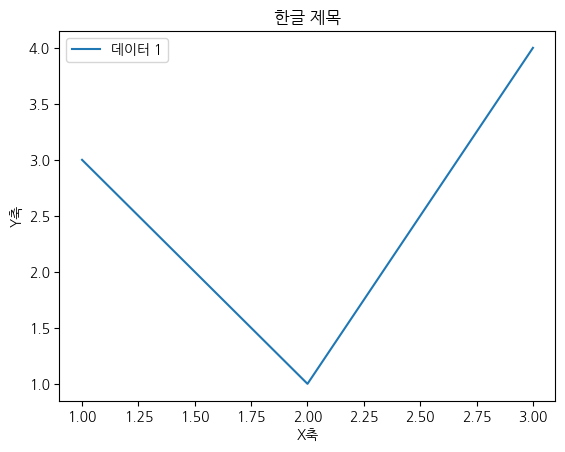

In [4]:
!pip install -q koreanize-matplotlib

# import순서 중요
import matplotlib.pyplot as plt
import koreanize_matplotlib

plt.plot([1, 2, 3], [3, 1, 4], label="데이터 1")
plt.title("한글 제목")
plt.xlabel("X축"); plt.ylabel("Y축"); plt.legend()
plt.show()

📄 Baseline 데이터 크기: (50, 4)
📄 SFT 데이터 크기: (50, 4)
📄 PPO 데이터 크기: (50, 4)

📊 통합 데이터 크기: (150, 4)

🧠 SentenceTransformer 임베딩 생성 중...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ 임베딩 완료!

📏 유사도 지표 계산 중...
✅ 모든 지표 계산 완료!

📊 모델별 평균 유사도 요약 (정렬됨):
          cosine  euclidean  pearson
모델명                                 
Baseline  0.6336     0.2812   0.6336
SFT       0.7633     0.3402   0.7633
PPO       0.6992     0.3045   0.6993 

📈 PPO - SFT 차이:
cosine      -0.0641
euclidean   -0.0357
pearson     -0.0640
dtype: float32

🚀 향상률 (%):
cosine       -8.40
euclidean   -10.49
pearson      -8.38
dtype: float32


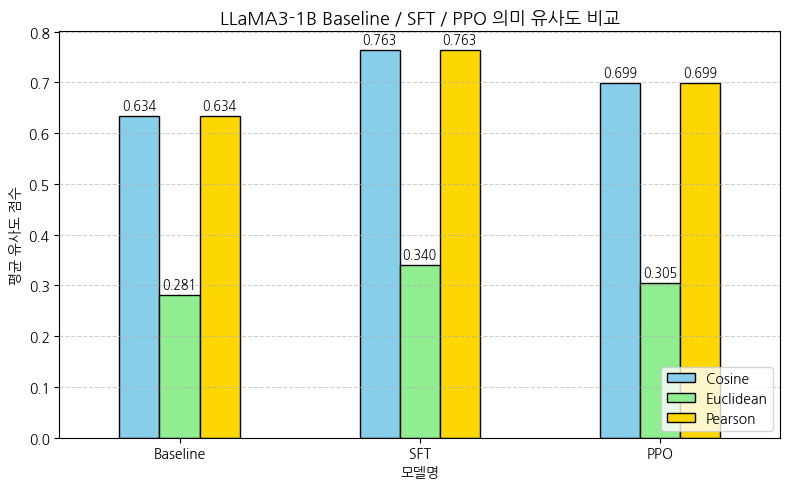

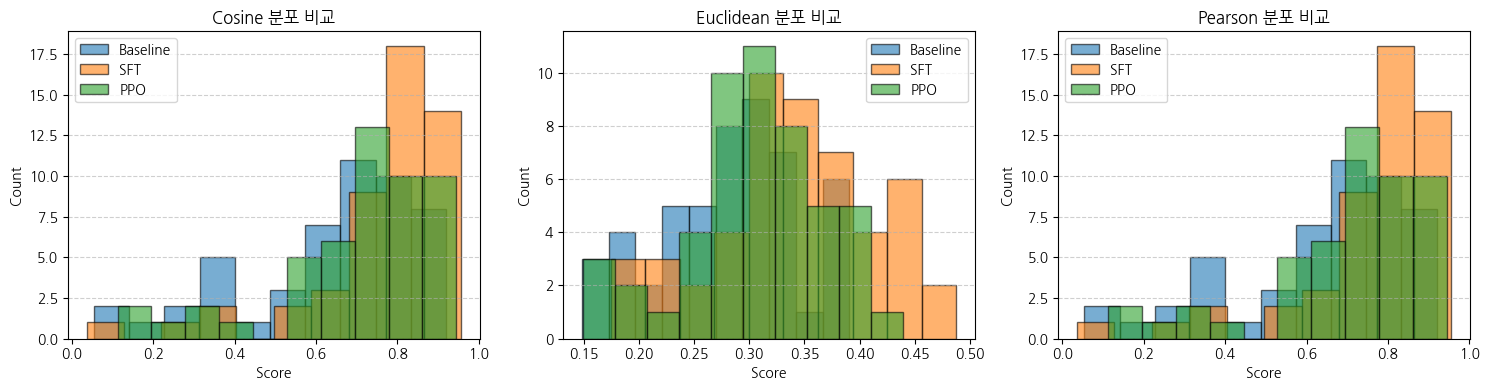

📋 최종 비교 요약:

            cosine  euclidean  pearson
모델명                                   
Baseline    0.6336     0.2812   0.6336
SFT         0.7633     0.3402   0.7633
PPO         0.6992     0.3045   0.6993
SFT→PPO(Δ) -0.0641    -0.0357  -0.0640
SFT→PPO(%) -8.4000   -10.4900  -8.3800
💾 요약 결과 저장 완료 → /content/drive/MyDrive/project2/1031/llama3_eval_summary.csv


In [7]:
# ============================================================
# 1. 라이브러리 로드
# ============================================================
#!pip install koreanize-matplotlib --quiet

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import platform
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sentence_transformers import SentenceTransformer
from scipy.stats import pearsonr
import koreanize_matplotlib

# ------------------------------------------------------------
# 한글 폰트 설정
# ------------------------------------------------------------
system = platform.system()
if system == "Windows":
    plt.rcParams["font.family"] = "Malgun Gothic"
elif system == "Darwin":  # macOS
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux / Colab
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        plt.rcParams["font.family"] = "DejaVu Sans"
        print("⚠️ 한글 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
plt.rcParams["axes.unicode_minus"] = False

# ============================================================
# 2. 파일 경로 설정
# ============================================================
files = {
    "Baseline": os.path.abspath("/content/drive/MyDrive/project2/project_2/sample_result/llama3_1b_baseline_results.csv"),
    "SFT": os.path.abspath("/content/drive/MyDrive/project2/1031/sft1031.csv"),
    "PPO": os.path.abspath("/content/drive/MyDrive/project2/1031/final_results2.csv"),
}

dfs = {}
for name, path in files.items():
    df = pd.read_csv(path)
    df["모델명"] = name
    df["모델_응답"] = df.get("모델_응답", "").fillna("")
    df["정답(데이터셋)"] = df.get("정답(데이터셋)", "").fillna("")
    dfs[name] = df
    print(f"📄 {name} 데이터 크기: {df.shape}")

# 통합
all_df = pd.concat(dfs.values(), ignore_index=True)
print(f"\n📊 통합 데이터 크기: {all_df.shape}\n")

# ============================================================
# 3. 임베딩 계산 (Semantic Similarity)
# ============================================================
print("🧠 SentenceTransformer 임베딩 생성 중...")
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

ref_emb = model.encode(all_df["정답(데이터셋)"].tolist(), convert_to_tensor=True)
pred_emb = model.encode(all_df["모델_응답"].tolist(), convert_to_tensor=True)

ref_np = ref_emb.cpu().numpy()
pred_np = pred_emb.cpu().numpy()
print("✅ 임베딩 완료!\n")

# ============================================================
# 4. 지표 계산 (Cosine / Euclidean / Pearson)
# ============================================================
print("📏 유사도 지표 계산 중...")

cosine_scores = cosine_similarity(pred_np, ref_np).diagonal()
euclid_dist = euclidean_distances(pred_np, ref_np).diagonal()
euclid_scores = 1 / (1 + euclid_dist)

pearson_scores = []
for i in range(len(ref_np)):
    corr, _ = pearsonr(ref_np[i], pred_np[i])
    pearson_scores.append(corr)
pearson_scores = np.nan_to_num(pearson_scores)

all_df["cosine"] = cosine_scores
all_df["euclidean"] = euclid_scores
all_df["pearson"] = pearson_scores
print("✅ 모든 지표 계산 완료!\n")

# ============================================================
# 5. 모델별 평균 비교
# ============================================================
summary = (
    all_df.groupby("모델명")[["cosine", "euclidean", "pearson"]]
    .mean()
    .round(4)
)

# ✅ Baseline → SFT → PPO 순서 고정
desired_order = ["Baseline", "SFT", "PPO"]
summary = summary.reindex(desired_order)

print("📊 모델별 평균 유사도 요약 (정렬됨):")
print(summary, "\n")

# ============================================================
# 6. SFT ↔ PPO 비교 수치
# ============================================================
if "PPO" in summary.index and "SFT" in summary.index:
    diff = (summary.loc["PPO"] - summary.loc["SFT"]).round(4)
    improvement = ((summary.loc["PPO"] - summary.loc["SFT"]) / summary.loc["SFT"] * 100).round(2)
    print("📈 PPO - SFT 차이:")
    print(diff)
    print("\n🚀 향상률 (%):")
    print(improvement)
else:
    print("⚠️ PPO 또는 SFT 결과가 없어서 비교를 건너뜁니다.")

# ============================================================
# 7. 시각화: 평균 유사도 막대 그래프
# ============================================================
plt.figure(figsize=(8, 5))
summary.plot(kind="bar", ax=plt.gca(), color=["skyblue", "lightgreen", "gold"], edgecolor="black")
plt.title("LLaMA3-1B Baseline / SFT / PPO 의미 유사도 비교", fontsize=13)
plt.ylabel("평균 유사도 점수")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(["Cosine", "Euclidean", "Pearson"], loc="lower right")

# 각 막대 위 수치 표시
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.3f", fontsize=9, label_type="edge", padding=3)
plt.tight_layout()
plt.show()

# ============================================================
# 8. 시각화: 각 지표 분포 (히스토그램)
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
metrics = ["cosine", "euclidean", "pearson"]

for i, m in enumerate(metrics):
    for name in desired_order:  # ✅ Baseline → SFT → PPO 순서 유지
        subset = all_df[all_df["모델명"] == name]
        axes[i].hist(subset[m], bins=10, alpha=0.6, label=name, edgecolor="black")
    axes[i].set_title(f"{m.capitalize()} 분포 비교")
    axes[i].set_xlabel("Score")
    axes[i].set_ylabel("Count")
    axes[i].grid(axis="y", linestyle="--", alpha=0.6)
    axes[i].legend()

plt.tight_layout()
plt.show()

# ============================================================
# 9. 요약 테이블 출력 및 저장
# ============================================================
# SFT→PPO 변화 계산 후 컬럼 추가
if "PPO" in summary.index and "SFT" in summary.index:
    delta = (summary.loc["PPO"] - summary.loc["SFT"]).round(4)
    percent = ((summary.loc["PPO"] - summary.loc["SFT"]) / summary.loc["SFT"] * 100).round(2)
else:
    delta = pd.Series(np.nan, index=summary.columns)
    percent = pd.Series(np.nan, index=summary.columns)

compare_df = summary.copy()
compare_df.loc["SFT→PPO(Δ)"] = delta
compare_df.loc["SFT→PPO(%)"] = percent

print("📋 최종 비교 요약:\n")
print(compare_df)

# 저장 경로
save_path = "/content/drive/MyDrive/project2/1031/llama3_eval_summary.csv"
compare_df.to_csv(save_path, encoding="utf-8-sig")
print(f"💾 요약 결과 저장 완료 → {save_path}")

In [ ]:
print("📍 summary 인덱스 목록:", summary.index.tolist())

📍 summary 인덱스 목록: ['Baseline', 'SFT', 'PPO']


📄 PPO 데이터 크기: (50, 3)
열 이름: ['질문', '모델_응답', '정답(데이터셋)'] 

🧠 SentenceTransformer 임베딩 계산 중...
✅ 임베딩 및 유사도 계산 완료!

📊 기본 통계 요약:
       semantic_similarity    응답길이
count               50.000   50.00
mean                 0.699  202.74
std                  0.190   54.98
min                  0.112    8.00
25%                  0.636  196.00
50%                  0.762  215.00
75%                  0.832  234.75
max                  0.944  266.00

✨ 유사도 상위 3개 질문 (PPO):

[23] 가상현실은 혁신 기술 분야인가?
유사도: 0.944
모델 응답: 가상현실은 혁신 기술 분야입니다. 가상현실은 컴퓨터, 네트워크, 소프트웨어, 인공지능, 데이터 분석 등 다양한 분야에서 혁신적인 기술을 적용하여 새로운 서비스를 제공하는 데 도움을 줍니다. 가상현실은 다양한 분야에서 혁신적인 기술을 적용하여 새로운 서비스를 제공하는 데 도움을 줍니다. 가상현실은 컴퓨터, 네트워크, 소프트웨어, 인공지능, 데이터 분석 등 다양한 분야에서 혁신적인 기술을 적용하여 새로운 서비스를 제공하는
정답: 네, 가상현실은 혁신 기술 분야입니다. 가상현실은 실제와 유사한 경험을 제공하며 사용자를 다른 현실로 몰입시키는 기술입니다. 이를 통해 사용자들은 가상의 세계에서 상호작용하고 다양한 경험을 할 수 있습니다. 가상현실은 게임, 교육, 의료, 엔터테인먼트 등 다양한 산업 분야에서 혁신적인 변화를 가져오고 있습니다.

[39] 도덕적 문제에 대한 대화와 토론은 왜 필요한가요?
유사도: 0.896
모델 응답: 도덕적 문제에 대한 대화와 토론은 도덕적 문제에 대한

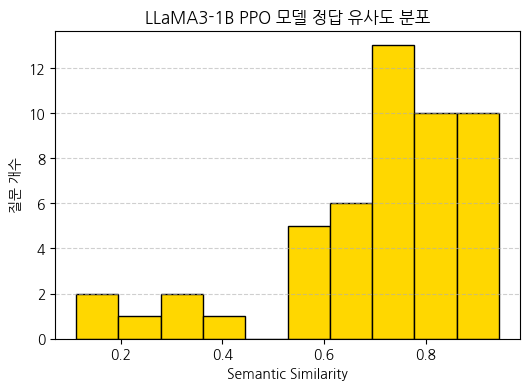

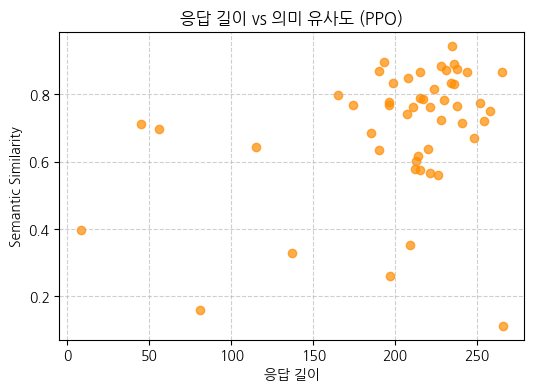

💾 분석 결과 저장 완료 → /content/drive/MyDrive/project2/1031/ppooofinal_results2.csv


In [8]:
# =========================================================
# 1. 라이브러리 로드
# =========================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from matplotlib import rc
import platform
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# ---------------------------------------------------------
# 한글 폰트 설정
# ---------------------------------------------------------
system = platform.system()
if system == 'Windows':
    plt.rcParams["font.family"] = "Malgun Gothic"
elif system == 'Darwin':  # macOS
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux / Colab
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        plt.rcParams["font.family"] = "DejaVu Sans"
        print("⚠️ 한글 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")

plt.rcParams["axes.unicode_minus"] = False

# =========================================================
# 2. PPO 결과 파일 로드
# =========================================================
path = "/content/drive/MyDrive/project2/1031/final_results2.csv"  # ✅ PPO 결과 경로
df = pd.read_csv(path)

print(f"📄 PPO 데이터 크기: {df.shape}")
print("열 이름:", df.columns.tolist(), "\n")

# NaN 방지
df["모델_응답"] = df["모델_응답"].fillna("")
df["정답(데이터셋)"] = df["정답(데이터셋)"].fillna("")

# =========================================================
# 3. 의미 유사도 계산 (Semantic Similarity)
# =========================================================
print("🧠 SentenceTransformer 임베딩 계산 중...")
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

ref_emb = model.encode(df["정답(데이터셋)"], convert_to_tensor=True)
pred_emb = model.encode(df["모델_응답"], convert_to_tensor=True)

# 코사인 유사도
df["semantic_similarity"] = cosine_similarity(pred_emb.cpu(), ref_emb.cpu()).diagonal()

print("✅ 임베딩 및 유사도 계산 완료!\n")

# =========================================================
# 4. 응답 길이 분석
# =========================================================
df["응답길이"] = df["모델_응답"].str.len()

print("📊 기본 통계 요약:")
print(df[["semantic_similarity", "응답길이"]].describe().round(3))

# =========================================================
# 5. 상위 / 하위 질문 확인
# =========================================================
top3 = df.nlargest(3, "semantic_similarity")[["질문", "모델_응답", "정답(데이터셋)", "semantic_similarity"]]
low3 = df.nsmallest(3, "semantic_similarity")[["질문", "모델_응답", "정답(데이터셋)", "semantic_similarity"]]

print("\n✨ 유사도 상위 3개 질문 (PPO):")
for i, row in top3.iterrows():
    print(f"\n[{i+1}] {row['질문']}")
    print(f"유사도: {row['semantic_similarity']:.3f}")
    print("모델 응답:", row['모델_응답'])
    print("정답:", row['정답(데이터셋)'])

print("\n⚠️ 유사도 하위 3개 질문 (PPO):")
for i, row in low3.iterrows():
    print(f"\n[{i+1}] {row['질문']}")
    print(f"유사도: {row['semantic_similarity']:.3f}")
    print("모델 응답:", row['모델_응답'])
    print("정답:", row['정답(데이터셋)'])

# =========================================================
# 6. 시각화
# =========================================================
plt.figure(figsize=(6,4))
plt.hist(df["semantic_similarity"], bins=10, color="gold", edgecolor="black")
plt.title("LLaMA3-1B PPO 모델 정답 유사도 분포")
plt.xlabel("Semantic Similarity")
plt.ylabel("질문 개수")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df["응답길이"], df["semantic_similarity"], color="darkorange", alpha=0.7)
plt.title("응답 길이 vs 의미 유사도 (PPO)")
plt.xlabel("응답 길이")
plt.ylabel("Semantic Similarity")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# =========================================================
# 7. 결과 저장 (선택)
# =========================================================
save_path = "/content/drive/MyDrive/project2/1031/ppooofinal_results2.csv"
df.to_csv(save_path, index=False, encoding="utf-8-sig")
print(f"💾 분석 결과 저장 완료 → {save_path}")